# Setup

In [8]:
# import statements
import subprocess
import os
import pandas as pd
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios
import parameter_optimization as po
import matplotlib.cm as cm
import matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.cluster import DBSCAN
import math
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random

# Griff's stuff
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

import promoter_solving_core as ps
import GA_core as ga

from deap import algorithms, base, creator, tools
from sympy import *

In [9]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : False,
    'central_gene' : 'b1101',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'base_cInhibitor_val' : 0.01, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.01, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # UNTESTED RIGHT NOW, I mean the code works, I'm just not sure if this is a good idea currently if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'cActivator' : [-2,2], # Uses a log10 range
    'cInhibitor': [-2,2], # Uses a log10 range
    
    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'use_greedy' : False, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818', 'b1819'] # if run_on_all is False, limit to these samples (or which of them are available)
}


gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
t_half_life_deg = 300
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    #'KeqOpening': 10**-0.34444956947383365, gets set later
    'RNAP': 10**-6,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'k_d_TF': 1, # May change depending on model
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
}

eq_str = 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))'

if os.path.exists('../data/gene_to_grid_constants.pkl'):
    pickle_in = open('../data/gene_to_grid_constants.pkl', 'rb')
    gene_to_grid_constants = pickle.load(pickle_in)
    pickle_in.close()
else:
    gene_to_grid_constants = {}
    
# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

# basal model calculations

In [10]:
# NOTE: This code is meant to be a placeholder since it only outputs the grid for each gene
# In the future, when we move towards a promoter based model, this code will need to be replaced with promoter specific calculations

# Define constants
log_test = {
    'KdRNAP': [-7,-5],
    'kEscape': [-3,1],
}

# Parameter Equation
parameter_equation = sympify('Eq((KeqOpening*kEscape*promoterConcVal)/((KdRNAP/RNAP+1+KeqOpening+KdRNAP/RNAP*TF/k_d_TF)*(u+kDeg)),mRNA)')

# Load in the precise data for gene expression
# NOTE: In the basal model I'm building, I am using the Precise1k data, but in this cell I will try to use the Precise1.0
precise_path = '../data/precise_1.0/log_tpm.csv'
precise_data = pd.read_csv(filepath_or_buffer = precise_path, index_col = 'Unnamed: 0')

gene_exp = [2**precise_data.loc[flags['central_gene'], flags['basal_conditions']].mean(axis = 0)]

# Only using num_steps = 3 to make it easier to manually iterate through the values, feel free to increase it if you'd like
lambda_df, k_df = ps.create_grid(gene_exp = gene_exp, gene_name = [flags['central_gene']], equation = parameter_equation, constants = grid_constants, num_steps = 3, **log_test)
grid_vals = k_df.iloc[0, 1][-1]
grid_constants['KdRNAP'] = 10**(grid_vals[0])
grid_constants['kEscape'] = 10**(grid_vals[1])
grid_constants['KeqOpening'] = 10**(grid_vals[2])

# load in calculator
po.create_shared_lambda_df(eq_str, grid_constants)

# create mRNA ratios and MA values

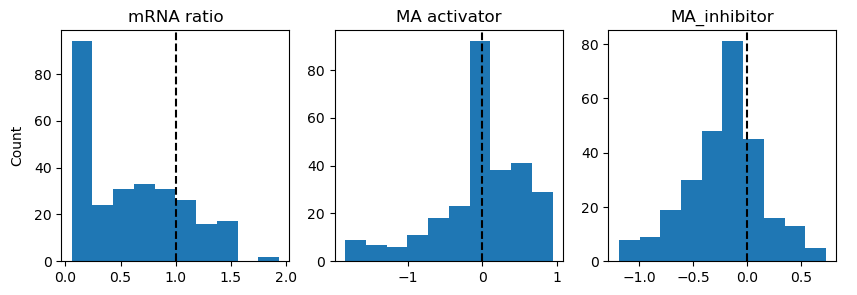

In [25]:
# reads / creates the ratio dataframe
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mRNA_ratios.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)


# save TF concentration (not sure this is right, but it appears to be close given I don't have raw counts)
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
scaled_df = 2**log_tpm_df / (2**log_tpm_df).sum()

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df.loc['b3357'].to_csv('../data/save_for_GAMs/exported_TF_conc.csv')

# sanity check plot
fig, axs = plt.subplots(1, 3, figsize = (10, 3))
axs[0].hist(ratios_df.actual_mRNA_ratio)
axs[0].set_title('mRNA ratio')
axs[0].axvline(x = 1, c = 'k', ls = '--')
axs[1].hist(ratios_df.MA_activator)
axs[1].set_title('MA activator')
axs[1].axvline(x = 0, c = 'k', ls = '--')
axs[2].hist(ratios_df.MA_inhibitor)
axs[2].set_title('MA_inhibitor')
axs[2].axvline(x = 0, c = 'k', ls = '--')
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('Count')
plt.show()

# pick KdRNAPCrp value, check solution space

In [5]:
# currently, this is picked based on assumming cInhibitor = cInh_base and performing the following:
# 1 a- Limit KdRNAPCrp to be less than KdRNAP
# 2 - Adjust KdRNAPCrp lower until there is no longer an inflection point within the mRNA ratio range of the said gene
# 3 - Adjust KdRNAPCrp to a value that maximizes the linearity and the magnitude of the range
#         a - Basically if just do magnitude it creates an exponentail curve that really only activates at extreme values, the linearity forces this to have more of a dynamic range
grid_constants['KdRNAPCrp'] = po.pick_KdRNAPCrp(ratios_df, initial_guess_ratio = flags['initial_guess_ratio'],
                                                min_cInh = flags['base_cInhibitor_val'])
gene_to_grid_constants.update({flags['central_gene'] : grid_constants})
pickle_out = open('../data/gene_to_grid_constants.pkl', 'wb')
pickle.dump(gene_to_grid_constants, pickle_out)
pickle_out.close()

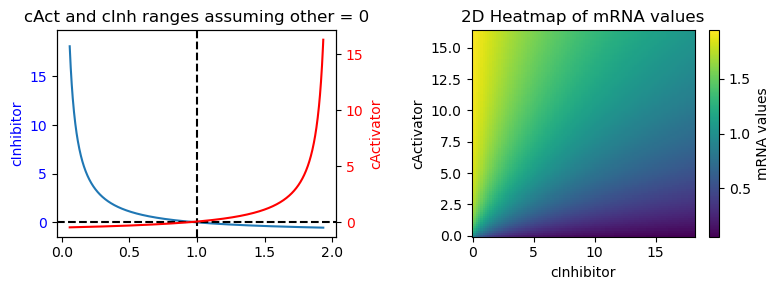

In [6]:
# sanity check plot

# if you get weird results here, look at egulonML/parameter_optimization/0_framework.ipynb
# it does the same thing as the function with plots along the way
# try adjusting the initial guess for the first optimization
# that is line 74 of functions/parameter_optimization.py

# note - This isn't perfect, as it assumes a non-true condition (the other equals zero)
# however, it is a sanity check to see if these values are near-correct
rat_vals = np.linspace(min(ratios_df['actual_mRNA_ratio'].values.flatten()), max(ratios_df['actual_mRNA_ratio'].values.flatten()), 1000)

cInh_vals = [po.mRNA_cActivator_to_cInhibitor(rat_val, flags['base_cActivator_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]
cAct_vals = [po.mRNA_cInhibitor_to_cActivator(rat_val, flags['base_cInhibitor_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]

fig, axs = plt.subplots(1, 2, figsize = (8, 3))
ax1 = axs[0]
l1, = ax1.plot(rat_vals, cInh_vals)
plt.xlabel('mRNA Ratio')
ax1.set_ylabel('cInhibitor', color = 'blue')
ax1.tick_params(axis = 'y', labelcolor = 'blue')
ax2 = ax1.twinx()
l2, = ax2.plot(rat_vals, cAct_vals, color = 'red')
ax2.set_ylabel('cActivator', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax1.axhline(y = 0, ls = '--', c = 'k')
ax1.axvline(x = 1, ls = '--', c = 'k')
# let's rescale cInhibitor (ax1) so that 0 is at the same point
m1, M1 = ax1.get_ylim()
percent1_up = (0 - m1) / (M1 - m1)
m2, M2 = ax2.get_ylim()
percent2_up = (0 - m2) / (M2 - m2)

if percent1_up < percent2_up:
    # zero is higher than it should, so adjust it down by lowering the min
    m1 = percent2_up * M1 / (percent2_up - 1)
    ax1.set_ylim(m1, M1)
else:
    # zero is lower than it should, so adjust it up
    M1 = m1 - (m1 / percent2_up)
    ax1.set_ylim(m1, M1)

ax1.set_title('cAct and cInh ranges assuming other = 0')

if flags['auto_set_max_range']:
    flags['cActivator'] = [-2, math.log10(max(cAct_vals))] # Uses a log10 range
    flags['cInhibitor'] = [-2, math.log10(max(cInh_vals))] # Uses a log10 range
    
# let's create a 2D heatmap version of this, colored by the mRNA ratio
cInh_range = np.linspace(0, max(cInh_vals), 100)
cAct_range = np.linspace(0, max(cAct_vals), 100)
mRNA_vals = pd.DataFrame(index = cInh_range, columns = cAct_range)
for cInh in mRNA_vals.index:
    for cAct in mRNA_vals.columns:
        mRNA_vals.loc[cInh][cAct] = po.cActivator_cInhibitor_to_mRNA(cAct, cInh, grid_constants['KdRNAPCrp'])
mRNA_vals = mRNA_vals.T.astype(float)

# Convert the cInh_range and cAct_range to meshgrids for plotting
cInh, cAct = np.meshgrid(cInh_range, cAct_range)

# Create the heatmap
heatmap = axs[1].pcolormesh(cInh, cAct, mRNA_vals.values, shading='auto', cmap='viridis')
plt.colorbar(heatmap, label='mRNA values')
axs[1].set_xlabel('cInhibitor')
axs[1].set_ylabel('cActivator')
axs[1].set_title('2D Heatmap of mRNA values')
plt.tight_layout()
plt.show()

# Determine the Best cActivator and cInhibitor Values

## Create the Combined cAct and cInh Grid

### Create the Grid

In [7]:
# DataFrame to hold the Grid
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = ratios_df.index)
grid.loc[:,'mRNA_ratio'] = ratios_df.loc[:,'actual_mRNA_ratio']

# Load the equation
# NOTE: This equation was generated using Mathematica and Dan's Mathematica to Python converter function
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [8]:
# Create lambda functions that we can plug in to
# TODO investigate this, at some point between the first four lines of the loop and the end
# create large values that don't respect the limits imposed upon them, I need to figure out
# how this loop works and figure out where that bug is
lambda_df = ps.create_lambdas(equation, grid_constants)

cAct_range = {'cActivator': flags['cActivator']} # Use a log10 range
cInh_range = {'cInhibitor': flags['cInhibitor']} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = ps.create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = ps.create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])
    
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids
        
    working_grid = sorted(cAct_grid + cInh_grid)
    
    # remove out of range elements
    new_work = []
    for vals in working_grid:
        cAct_val, cInh_val = vals
        if cAct_val < 10**cAct_range['cActivator'][0] or cAct_val > 10**cAct_range['cActivator'][1]:
            continue
        if cInh_val < 10**cInh_range['cInhibitor'][0] or cInh_val > 10**cInh_range['cInhibitor'][1]:
            continue
        new_work.append(vals)
    working_grid = new_work
    
    # Remove negative elements from working_grid
    if flags['neg_grid_toss_OR_zero'] == 'toss':
        working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]
    elif flags['neg_grid_toss_OR_zero'] == 'zero':
        new = []
        for cAct, cInh in working_grid:
            if cAct >= 0 and cInh >= 0:
                new.append((cAct, cInh))
            elif cAct < 0 and cInh < 0:
                new.append((0, 0))
            elif cAct < 0:
                new.append((0, cInh))
            else: # this is cInh is negative and cAct isn't
                new.append((cAct, 0))
        working_grid = new

    # Save to grid df
    grid.at[condition, 'grid'] = working_grid
    
# remove empty grids
to_remove = []
max_grid = max([len(g) for g in grid.grid])
for index, row in grid.iterrows():
    g = row['grid']
    if len(g) == 0:
        to_remove.append(index)

# some conditions just aren't mappable (TF KO's being one), let's drop them for now
grid = grid.drop(to_remove)
ratios_df = ratios_df.drop(to_remove)


### Scatter Condition's Grid with Histograms

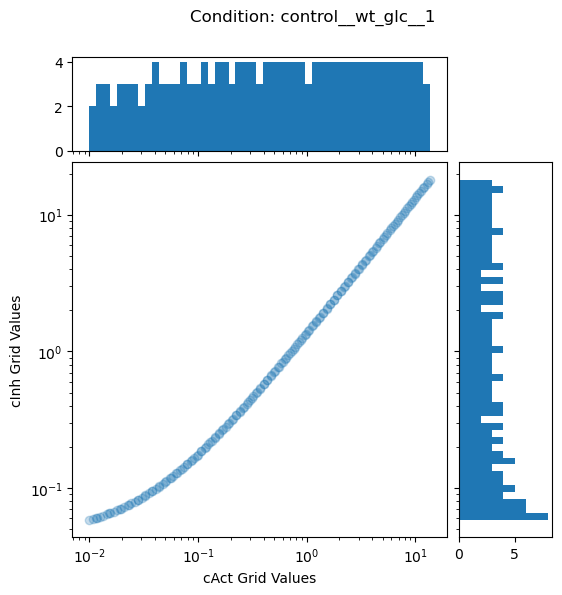

In [9]:
#
i = 0 # The integer corresponding to the condition of interest index

x = [cAct for (cAct, _) in grid.iloc[i,1]]
y = [cInh for (_, cInh) in grid.iloc[i,1]]

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(x, y, alpha=0.25)

x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
y_bins = np.logspace(np.log10(min(y)), np.log10(max(y)), 50)

ax_histx.hist(x, bins=x_bins)
ax_histy.hist(y, bins=y_bins, orientation='horizontal')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cAct Grid Values')
ax.set_ylabel('cInh Grid Values')

fig.suptitle('Condition: '+str(grid.index[i]))
plt.show()

## Setup and Run the GA

In [10]:
# Create fitness and individual objects
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               shape = (len(grid),), # Number of conditions
               dtype = np.dtype([('act', float), ('inh', float)]), # Custom dtype
               fitness = creator.fitness)

# Import toolbox
toolbox = base.Toolbox()

# Register the individual and population functions
toolbox.register(alias = 'individual',
                 function = ga.generate_individual,
                 individual_class = creator.individual,
                 grid = grid.grid,
                 rng = rng)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

# Register the evaluation function
toolbox.register(alias = 'evaluate',
                function = ga.spearman_objective,
                MA_df = ratios_df.loc[:,['MA_activator','MA_inhibitor']])

# Register the selection algorithm
toolbox.register(alias = "select", 
                 function = tools.selNSGA2, 
                 nd = 'log') 
# I've been using selNSGA2 since it seems to run faster
#toolbox.register("select", tools.selSPEA2)

# Register the mutation function
toolbox.register(alias = 'mutate', 
                 function = ga.mutate, 
                 prob = flags['mt_prob'], 
                 grid = grid.grid, 
                 rng = rng)

# Register the crossover function
cx_prob = 0.6 # NOTE: These values were chosen based on brute_force.ipynb
toolbox.register(alias = "mate", 
                 function = ga.crossover, 
                 prob = flags['cx_prob'],
                 rng = rng)

# Set the statistics to record the best individual score of each generation in 
# the logbook
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],
                                                     ind.fitness.values[1]))

# Run the GA
pop, logbook = ga.mu_plus_lambda(pop = toolbox.population(n = flags['n_ind']), 
                                 toolbox = toolbox, 
                                 rng = rng, 
                                 mu = flags['mu'], 
                                 lambda_ = flags['lambda_'], 
                                 cxpb = flags['cxpb'], 
                                 mutpb = flags['mutpb'], 
                                 n_gen = flags['n_gen'], 
                                 stats = stats, 
                                 verbose = flags['verbose'])

### Check GA Results

In [11]:
total_score, total_sort = ga.best_individual(pop)
total_score[total_sort[-1]]

1.4493442475630456

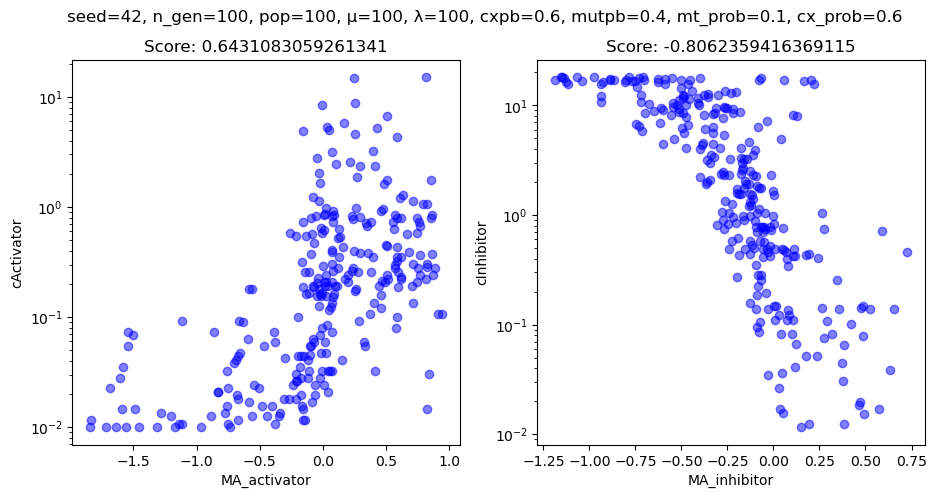

In [12]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = pop[total_sort[-1]],
                                     MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                     GA_parameters = flags)

fig.show()

In [13]:
# save the non-greedy version
GAMs_individual = pop[total_sort[-1]]

vals_for_GAMs = pd.DataFrame(index = ratios_df.index,
                             columns = ['cAct', 'cInh'],)

vals_for_GAMs.cAct = list(GAMs_individual['act'])
vals_for_GAMs.cInh = list(GAMs_individual['inh'])

# save for GAMs
df_name = flags['central_gene']+'_non_greed_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
file_out = '../data/save_for_GAMs/'+df_name
vals_for_GAMs.to_csv(file_out)

## Run the Greedy Algorithm

In [14]:
greedy_pop = ga.greedy_algorithm(base_individual = pop[total_sort[-1]], 
                                 n_iterations = flags['n_iter'],
                                 grid = grid.grid,
                                 toolbox = toolbox,
                                 max_steps = flags['max_steps'],
                                 n_rounds = flags['n_rounds'])

greedy_score, greedy_sort = ga.best_individual(greedy_pop)
greedy_score[greedy_sort[-1]]

KeyboardInterrupt: 

In [ ]:
greedy_voting = ga.voting(population = greedy_pop,
                          grid = grid.grid)

# Convert from condition integer index to grid tuple to create mean_ind
mean_ind = creator.individual(greedy_pop[greedy_sort[-1]])
for i, _ in enumerate(mean_ind):
    mean_ind[i] = grid.grid[i][int(greedy_voting._mean[i])]

mean_ind.fitness.values = toolbox.evaluate(mean_ind)
print(np.subtract(mean_ind.fitness.values[0], mean_ind.fitness.values[1]))

In [ ]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = greedy_pop[greedy_sort[-1]],
                                        MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                        GA_parameters = None)

fig.show()

### Convert Chosen Individual to DataFrame

In [ ]:
GAMs_individual = greedy_pop[greedy_sort[-1]]

vals_for_GAMs = pd.DataFrame(index = ratios_df.index,
                             columns = ['cAct', 'cInh'],)

vals_for_GAMs.cAct = list(GAMs_individual['act'])
vals_for_GAMs.cInh = list(GAMs_individual['inh'])

### Save for GAMs (Avoid Overwriting Existing Files)

In [ ]:
# save for GAMs
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
file_out = '../data/save_for_GAMs/'+df_name
vals_for_GAMs.to_csv(file_out)

# run GAMs

In [4]:
# first let's merge together the files
files_use = []
if flags['run_on_all']:
    files = os.listdir('../data/save_for_GAMs/')
    for f in files:
        if 'composite' in f: continue
        if 'zerod'+str(flags['use_zerod_A_matrix']) not in f: continue
        if flags['use_greedy'] and 'non_greed' in f: continue
        if not flags['use_greedy'] and 'non_greed' not in f: continue
        files_use.append(f)
else:
    for sample in flags['limit_samples']:
        if flags['use_greedy']:
            f_name = sample+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
        else:
            f_name = sample+'_non_greed_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
        if os.path.exists('../data/save_for_GAMs/'+f_name):
            files_use.append(f_name)
for f in files_use:
    shared_indices = []
    first = True
    for file in files_use:
        gene_name = file.split('_')[0]
        temp_df = pd.read_csv('../data/save_for_GAMs/'+file, index_col = 0)
        if first:
            shared_indices = set(temp_df.index)
            first = False
        else:
            shared_indices = set(shared_indices.intersection(set(temp_df.index)))
    shared_indices = list(shared_indices)
    shared_indices.sort()
    act_df = pd.DataFrame(index = shared_indices)
    inh_df = pd.DataFrame(index = shared_indices)
    for file in files_use:
        gene_name = file.split('_')[0]
        act_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file, index_col = 0)['cAct'].loc[act_df.index].values
        inh_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file, index_col = 0)['cInh'].loc[inh_df.index].values
act_df.to_csv('../data/save_for_GAMs/composite_cAct_vals.csv')
inh_df.to_csv('../data/save_for_GAMs/composite_cInh_vals.csv')

In [31]:
# call GAMs
_ = subprocess.call('gams cAct_model', shell = True, cwd = '../GAMs')
_ = subprocess.call('gams cInh_model', shell = True, cwd = '../GAMs')

--- Job cAct_model Start 11/01/23 16:17:18 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/cAct_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Demo, for EULA and demo limitations see   G230706/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Demo license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- cAct_model.gms(10) 2 Mb
--- call csv2gdx ../data/save_for_GAMs/composite_cAct_vals.csv id=cEff index=1 values=2..lastCol useHeader=y trace=0 output=./input_GDX/input.gdx
--- cAct_model.gms(11) 2 Mb
--

     81   4        2.7744551013E+02 6.9E-01   126 3.3E+00    1 F  T
     86   4        2.7741677902E+02 1.6E-01   124 1.6E-02    1 F  T
     91   4        2.7706221910E+02 9.0E-01   139 6.8E-01    1 F  T
    101   4        2.7689465933E+02 1.5E-01   136 7.0E-02      F  T
    106   4        2.7651655478E+02 1.5E+00   152 1.0E+01    1 F  T
    111   4        2.7625808585E+02 2.6E-01   150 2.9E-02    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    121   4        2.7622050490E+02 1.5E-01   146 7.4E-02      F  T
    131   4        2.7546350660E+02 3.2E-01   159 2.3E-02    1 F  T
    136   4        2.7543016838E+02 2.5E-01   157 1.6E-02    1 F  T
    141   4        2.7541546177E+02 3.9E-01   154 7.2E-02      F  T
    151   4        2.7540322938E+02 2.5E-01   152 6.8E-01    1 F  T
    156   4        2.7540027325E+02 1.2E-01   152 1.0E+00    1 F  T
    161   4        2.7460416897E+02 4.9E-01   173 4.5E-01      F  T
    166   4        2.7455486073E+02 3.0E-01  

    871   4        2.7338488846E+02 5.0E-01   149 1.0E+00    1 F  T
    876   4        2.7338486329E+02 2.7E-01   149 2.6E+00    1 F  T
    881   4        2.7338483900E+02 3.9E-01   149 5.1E-01    1 F  T
    886   4        2.7338470412E+02 2.5E-01   149 1.0E+00    1 F  T
    891   4        2.7338463906E+02 2.2E-01   149 3.7E-05    1 F  T
    896   4        2.7338462494E+02 5.0E-01   148 1.0E+00    1 F  T
    901   4        2.7338460556E+02 2.4E-01   146 6.5E-01      F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    911   4        2.7338456730E+02 3.9E-01   144 1.1E+01    1 F  T
    921   4        2.7338398240E+02 3.0E-01   150 1.0E+00      F  T
    931   4        2.7338384295E+02 3.6E-01   148 5.0E-01      F  T
    936   4        2.7338380863E+02 3.4E-01   147 5.5E+00    1 F  T
    941   4        2.7338375893E+02 4.7E-01   146 1.4E-05    1 F  T
    946   4        2.7338374769E+02 2.0E-01   143 5.7E-05    1 F  T
    951   4        2.7338373157E+02 2.6E-01  

   1541   4        2.7338300256E+02 2.7E-01    95 2.0E+02    1 F  T
   1546   4        2.7338300199E+02 4.0E-01    94 1.0E+01    1 F  T
   1551   4        2.7338300138E+02 2.3E-01    94 1.1E-03      F  T
   1556   4        2.7338300030E+02 4.9E-01    94 2.5E-05    1 F  T
   1561   4        2.7338299869E+02 4.9E-01    91 1.0E-03      F  T
   1571   4        2.7338299784E+02 2.9E-01    90 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   1576   4        2.7338299738E+02 3.1E-01    89 2.8E-07    1 F  T
   1581   4        2.7338299726E+02 1.3E-01    88 2.7E+00    1 F  T
   1591   4        2.7338299645E+02 2.5E-01    86 5.1E-04      F  T
   1596   4        2.7338299621E+02 4.7E-01    84 5.6E-07    1 F  T
   1601   4        2.7338299607E+02 1.9E-01    82 5.8E-08    1 F  T
   1611   4        2.7338299524E+02 2.3E-01    85 1.3E-03      F  T
   1616   4        2.7338299412E+02 3.5E-01    83 6.3E+01    1 F  T
   1621   4        2.7338299365E+02 3.3E-01  

   2311   4        2.7333908662E+02 1.9E-01    58 2.7E-04      F  T
   2316   4        2.7333908432E+02 2.9E-01    58 2.0E+01    1 F  T
   2321   4        2.7333908025E+02 3.2E-01    58 1.0E+00    1 F  T
   2326   4        2.7333907762E+02 2.2E-01    58 6.6E-06    1 F  T
   2331   4        2.7333907550E+02 2.2E-01    56 8.2E-07    1 F  T
   2341   4        2.7333907197E+02 1.6E-01    55 9.4E-03      F  T
   2346   4        2.7333906357E+02 1.7E-01    55 2.7E-06    1 F  T
   2351   4        2.7333906112E+02 3.2E-01    55 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2356   4        2.7333905893E+02 2.5E-01    54 1.0E+00    1 F  T
   2361   4        2.7333905776E+02 2.6E-01    53 2.0E-06    1 F  T
   2371   4        2.7333905506E+02 4.6E-01    53 5.0E-03      F  T
   2376   4        2.7333905402E+02 3.1E-01    53 8.2E+00    1 F  T
   2381   4        2.7333905276E+02 1.9E-01    53 1.0E+00    1 F  T
   2391   4        2.7333904747E+02 2.0E-01  

   2991   4        2.7333382022E+02 4.2E-01    36 1.6E-06    1 F  T
   3001   4        2.7333381589E+02 1.6E-01    35 9.7E-02      F  T
   3006   4        2.7333381492E+02 2.6E-01    35 3.7E+00    1 F  T
   3011   4        2.7333381400E+02 3.6E-01    34 1.2E-07    1 F  T
   3016   4        2.7333381369E+02 2.7E-01    32 1.7E-07    1 F  T
   3021   4        2.7333381262E+02 3.8E-01    35 9.4E-04      F  T
   3031   4        2.7333366390E+02 3.6E-01    33 3.4E+00    1 F  T
   3036   4        2.7333365640E+02 4.1E-01    32 2.5E+00    1 F  T
   3041   4        2.7333365312E+02 5.2E-01    31 2.3E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3046   4        2.7333364317E+02 3.2E-01    35 8.6E-06    1 F  T
   3051   4        2.7333364290E+02 3.1E-01    34 3.2E+00    1 F  T
   3056   4        2.7333363632E+02 1.5E-01    33 1.6E+00    1 F  T
   3061   4        2.7333363090E+02 2.9E-01    31 1.0E+00    1 F  T
   3066   4        2.7333362916E+02 3.7E-01  

/tmp/ipykernel_1125550/2421036291.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_1125550/2421036291.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


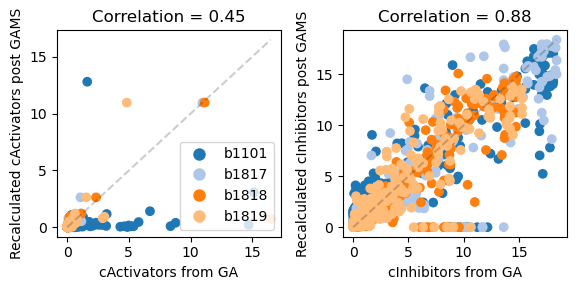

In [11]:
# look at GAMs results

# load in cActivators
saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cAct_vals.csv', index_col = 0)

# GAMS calculated cActivators
kd_df = 10**pd.read_csv('../data/GAMS_output/cAct_Kd_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators[kd_df.columns]
TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators.loc[TF_conc_df.columns]
calc_cAct = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cAct.columns:
    for gene in calc_cAct.index:
        calc_cAct.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
calc_cAct = calc_cAct.T


# plotting
saved = []
calc = []
labels = []
gene_to_color = {}
cmap = cm.get_cmap('tab20')
color_opts = iter(cmap.colors)
colors = []
for gene in calc_cAct.columns:
    if gene not in gene_to_color:
        gene_to_color.update({gene : next(color_opts)})
    color = gene_to_color[gene]
    for sample in calc_cAct.index:
        saved.append(saved_cActivators.loc[sample][gene])
        calc.append(calc_cAct.loc[sample][gene])
        labels.append(gene+', '+sample)
        colors.append(color)
fig, axs = plt.subplots(1, 2, figsize = (6, 3))
scatter = axs[0].scatter(saved, calc, c = colors)
axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
axs[0].set_xlabel('cActivators from GA')
axs[0].set_ylabel('Recalculated cActivators post GAMS')
corr = np.corrcoef(saved, calc)
axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
#plt.yscale('log')
#plt.xscale('log')

# Create an empty list to store legend handles and labels
legend_elements = []
for label, color in gene_to_color.items():
    legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
axs[0].legend(handles = legend_elements, loc = 'lower right')


# now plot cInhibitor
# load in cActivators
saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cInh_vals.csv', index_col = 0)

# GAMS calculated cActivators
kd_df = 10**pd.read_csv('../data/GAMS_output/cInh_Kd_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators[kd_df.columns]
TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
saved_cActivators = saved_cActivators.loc[TF_conc_df.columns]
calc_cInh = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cInh.columns:
    for gene in calc_cInh.index:
        calc_cInh.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
calc_cInh = calc_cInh.T

# plotting
saved = []
calc = []
labels = []
gene_to_color = {}
cmap = cm.get_cmap('tab20')
color_opts = iter(cmap.colors)
colors = []
for gene in calc_cInh.columns:
    if gene not in gene_to_color:
        gene_to_color.update({gene : next(color_opts)})
    color = gene_to_color[gene]
    for sample in calc_cInh.index:
        saved.append(saved_cActivators.loc[sample][gene])
        calc.append(calc_cInh.loc[sample][gene])
        labels.append(gene+', '+sample)
        colors.append(color)
scatter = axs[1].scatter(saved, calc, c = colors)
axs[1].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
axs[1].set_xlabel('cInhibitors from GA')
axs[1].set_ylabel('Recalculated cInhibitors post GAMS')
corr = np.corrcoef(saved, calc)
axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
#plt.yscale('log')
#plt.xscale('log')
fig.tight_layout()
plt.show()

# convert back to mRNA ratios

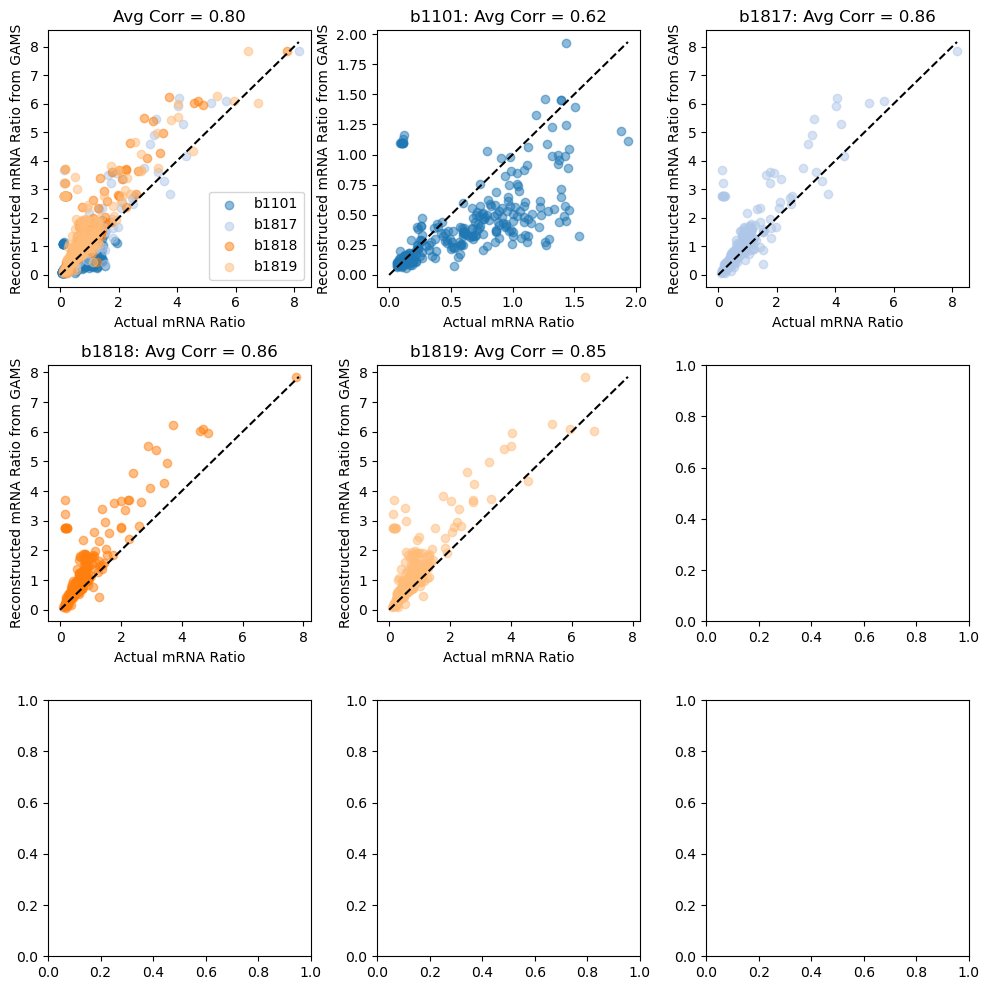

In [12]:
# there are a few types of re-converted mRNA ratios
# 1 the GA cActivator and cInhibitor, should get perfect recreation
# 2 using recreated cActivator and cInhibitor from the GAMs solution
    # to do this, I need to get cInhibitor working on GAMs, which I believe will be the same thing with different data

    
# I feel like I already did this and push merged over it, but I'll do it again
# I need recreated cActivators and cInhibitors
colors = iter(plt.cm.tab20.colors)
shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
corrs = []
max_mRNA = 0
dims = int(np.sqrt(len(calc_cAct.columns)))+1
fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
axs = axs.flatten()
#plt.figure(figsize = (4, 4))
g_ct = 1
for gene in calc_cAct.columns:
    grid = gene_to_grid_constants[gene]
    
    df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
    
    recon_mRNA = []
    for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
        recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))

    actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
    if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
        max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
    max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
    
    corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
    corrs.append(corr[0][1])
    c = next(colors)
    axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
    axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
    axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
    axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
    axs[g_ct].set_xlabel('Actual mRNA Ratio')
    axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
    g_ct += 1


axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
axs[0].legend()
axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
axs[0].set_xlabel('Actual mRNA Ratio')
axs[0].set_ylabel('Reconstructed mRNA Ratio from GAMS')
plt.tight_layout()
plt.show()

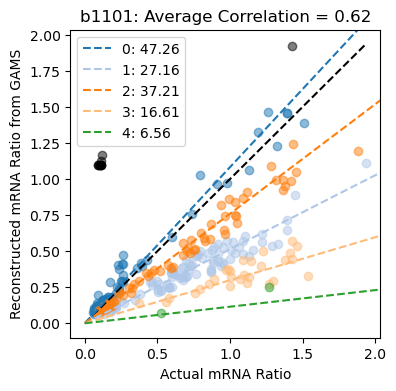

In [22]:
# play around with one particular gene
gene = 'b1101'
use_custom = True
top_deg_tol = 10
deg_search_ct = 5
min_sq_err = 0.1

if True:
    # I need recreated cActivators and cInhibitors
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    bby_calc_cAct = calc_cAct.loc[shared]
    bby_calc_cInh = calc_cInh.loc[shared]

    grid = gene_to_grid_constants[gene]

    df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
    
    recon_mRNA = []
    for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
        recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))
    recon_mRNA = np.array(recon_mRNA)
    
    actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
    max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

    corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
    corrs.append(corr[0][1])

    # clustering
    if use_custom: # I can't seem to find an existing clustering methodology for this weird relationship, but I'll need to do this a lot so I'm going to create one quickly
        # pseudocode to implement:
        # sweep through lines ranging from 0 to 90 degrees
        # calculate error for each individual point
        # total number of points with low errors (say less than 0.1 for now)
        # after all lines have been sweeped, look at onces with lowest errors
        # if multiple nearby lines all have low errors, pick the lowest one (only one line every 5 degrees say)
        # cluster points to which lines they have the lowest error towards
        # maybe scale teh error distance based on how high the values are? like a percentage thing?
        # XXX zzz
        def x_to_y(x, deg):
            rads = math.radians(deg)
            y = math.tan(rads) * x
            return(y)

        deg_to_close_ct = {}
        for deg in np.linspace(-5, 95, 200):
            ys = [x_to_y(x, deg) for x in actual_mRNA]
            errs = (recon_mRNA - ys)**2
            close_ct = list(errs < min_sq_err).count(True) # anything within 5% of correct count as a good fit
            deg_to_close_ct.update({deg : close_ct})
        top_degs_opts = [k for k, _ in sorted(deg_to_close_ct.items(), key = lambda key : -key[1])]
        top_degs = [top_degs_opts[0]]
        for deg in top_degs_opts:
            min_dist = min([abs(a - deg) for a in top_degs])
            if min_dist > top_deg_tol:
                top_degs.append(deg)
            if len(top_degs) > deg_search_ct:
                break

        deg_to_label = {}
        label_ct = 0
        labels = []
        for x, y in zip(actual_mRNA, recon_mRNA):
            # find line with least error for it
            min_err = 9e99
            best_deg = top_degs_opts[0]
            for deg in top_degs:
                pred_y = x_to_y(x, deg)
                err = (y - pred_y)**2
                if err < min_err:
                    best_deg = deg
                    min_err = err
            if best_deg not in deg_to_label:
                deg_to_label.update({best_deg : label_ct})
                label_ct += 1
            if min_err < min_sq_err:
                labels.append(deg_to_label[best_deg])
            else:
                labels.append(-1)
    else:
        clstr = DBSCAN()
        labels = clstr.fit_predict(np.column_stack((actual_mRNA, recon_mRNA)))

    colors = list(plt.cm.tab20.colors)
    label_opts = list(set(labels))
    label_to_color = {}
    class_mask = (np.array(labels) == -1)
    plt.figure(figsize = (4, 4))
    plt.scatter(actual_mRNA[class_mask], recon_mRNA[class_mask], c = 'k', alpha = 0.5)
    for label, color in zip(label_opts, colors[0:len(label_opts)]):
        if label == -1:
            continue
        class_mask = (np.array(labels) == label)
        label_to_color.update({label : color})
        plt.scatter(actual_mRNA[class_mask], recon_mRNA[class_mask], c = color, alpha = 0.5)
    plt.plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')

    if use_custom:
        for deg, label in deg_to_label.items():
            y_val = 100*math.tan(math.radians(deg))
            plt.plot([0, 100], [0, y_val], ls = '--', c = label_to_color[label], label = str(label)+': {:.2f}'.format(deg))

    plt.title(gene+': Average Correlation = {:.2f}'.format(corr[0][1]))
    plt.xlabel('Actual mRNA Ratio')
    plt.ylabel('Reconstructed mRNA Ratio from GAMS')
    plt.xlim([-0.1, max_bby_mRNA + 0.1])
    plt.ylim([-0.1, max_bby_mRNA + 0.1])
    plt.legend()
    plt.show()
    
    label_to_deg = {v : k for k, v in deg_to_label.items()}

## plot these clusters in other ways


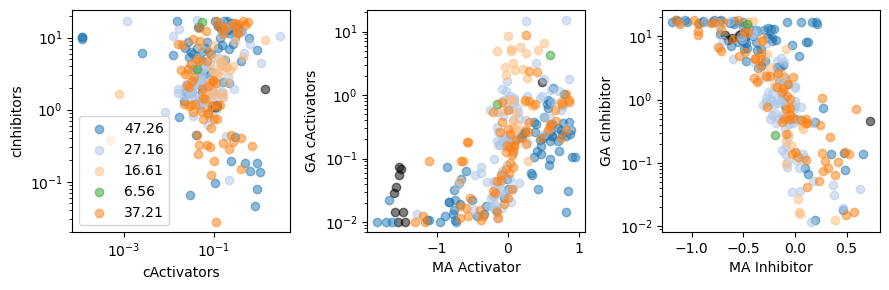

In [26]:
# start with cActivators and cInibitors
focus_cluster = 2 # plot this one last, if None ignored

if True:
    colors = list(plt.cm.tab20.colors)
    label_opts = list(set(labels))
    if focus_cluster != None:
        label_opts.remove(focus_cluster)
        label_opts.append(focus_cluster)
    base_class_mask = (np.array(labels) == -1)
    fig, axs = plt.subplots(1, 3, figsize = (9, 3))


    # first plot them against each other
    axs[0].scatter(actual_mRNA[base_class_mask], recon_mRNA[base_class_mask], c = 'k', alpha = 0.5)
    for label in label_opts:
        if label == -1:
            continue
        class_mask = (np.array(labels) == label)
        color = label_to_color[label]
        axs[0].scatter(bby_calc_cAct.iloc[class_mask][gene], bby_calc_cInh.iloc[class_mask][gene], label = '{:.2f}'.format(label_to_deg[label]), c = color, alpha = 0.5)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('cActivators')
    axs[0].set_ylabel('cInhibitors')
    axs[0].legend()

    # now plot cActivator against MA ratio (what it was trained on)
    axs[1].scatter(ratios_df.loc[bby_calc_cAct.index]['MA_activator'][base_class_mask], act_df.loc[bby_calc_cAct.index][gene][base_class_mask], c = 'k', alpha = 0.5)
    for label in label_opts:
        if label == -1:
            continue
        class_mask = (np.array(labels) == label)
        color = label_to_color[label]
        axs[1].scatter(ratios_df.loc[bby_calc_cAct.index]['MA_activator'][class_mask], act_df.loc[bby_calc_cAct.index][gene][class_mask], label = '{:.2f}'.format(label_to_deg[label]), c = color, alpha = 0.5)
    #axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('MA Activator')
    axs[1].set_ylabel('GA cActivators')

    # now plot cInhibitor against MA ratio (what it was trained on)
    axs[2].scatter(ratios_df.loc[bby_calc_cAct.index]['MA_inhibitor'][base_class_mask], inh_df.loc[bby_calc_cAct.index][gene][base_class_mask], c = 'k', alpha = 0.5)
    for label in label_opts:
        if label == -1:
            continue
        class_mask = (np.array(labels) == label)
        color = label_to_color[label]
        axs[2].scatter(ratios_df.loc[bby_calc_cAct.index]['MA_inhibitor'][class_mask], inh_df.loc[bby_calc_cAct.index][gene][class_mask], label = '{:.2f}'.format(label_to_deg[label]), c = color, alpha = 0.5)
    #axs[2].set_xscale('log')
    axs[2].set_yscale('log')
    axs[2].set_xlabel('MA Inhibitor')
    axs[2].set_ylabel('GA cInhibitor')

    plt.tight_layout()
    plt.show()

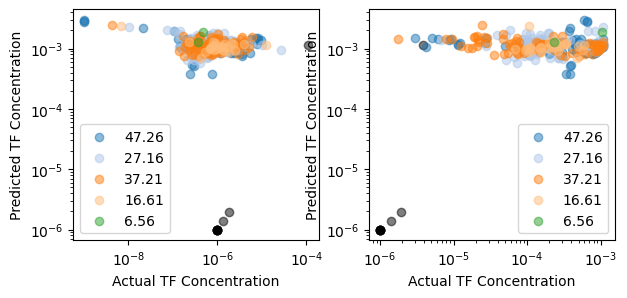

In [27]:
# histogram of TF_conc values
TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
TF_conc_df = TF_conc_df[bby_calc_cAct.index]
colors = list(plt.cm.tab20.colors)
label_opts = list(set(labels))
class_mask = (np.array(labels) == -1)
fig, axs = plt.subplots(1, 2, figsize = (7, 3))
axs[0].scatter(TF_conc_df.T.loc[bby_calc_cAct.index].iloc[class_mask], scaled_df.loc['b3357'].T.loc[bby_calc_cAct.index].iloc[class_mask], c = 'k', alpha = 0.5)
for label in label_opts:
    if label == -1:
        continue
    color = label_to_color[label]
    class_mask = (np.array(labels) == label)
    axs[0].scatter(TF_conc_df.T.loc[bby_calc_cAct.index].iloc[class_mask], scaled_df.loc['b3357'].T.loc[bby_calc_cAct.index].iloc[class_mask], label = '{:.2f}'.format(label_to_deg[label]), c = color, alpha = 0.5)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Actual TF Concentration')
axs[0].set_ylabel('Predicted TF Concentration')
axs[0].legend()

TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
TF_conc_df.T.loc[bby_calc_cInh.index]
class_mask = (np.array(labels) == -1)
axs[1].scatter(TF_conc_df.T.loc[bby_calc_cInh.index].iloc[class_mask], scaled_df.loc['b3357'].T.loc[bby_calc_cInh.index].iloc[class_mask], c = 'k', alpha = 0.5)
for label in label_opts:
    if label == -1:
        continue
    color = label_to_color[label]
    class_mask = (np.array(labels) == label)
    axs[1].scatter(TF_conc_df.T.loc[bby_calc_cAct.index].iloc[class_mask], scaled_df.loc['b3357'].T.loc[bby_calc_cAct.index].iloc[class_mask], label = '{:.2f}'.format(label_to_deg[label]), c = color, alpha = 0.5)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Actual TF Concentration')
axs[1].set_ylabel('Predicted TF Concentration')
axs[1].legend()


plt.show()

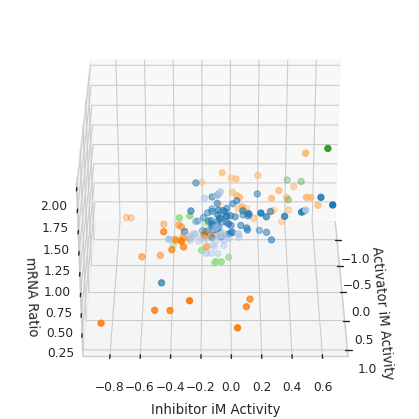

In [48]:
# 3D plot their mRNA values along the phase planes
shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
bby_calc_cAct = calc_cAct.loc[shared]
bby_calc_cInh = calc_cInh.loc[shared]
    
    
#plt.rcParams["figure.dpi"] = 300
#matplotlib.rcParams['pdf.fonttype'] = 42
#sns.set_palette("deep")
#sns.set_context("paper")
#sns.set_style("whitegrid")

# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols
fig = plt.figure(figsize = (4, 4))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


colors = list(plt.cm.tab20.colors)
label_opts = list(set(labels))
class_mask = (np.array(labels) == -1)
for label in label_opts:
    if label == -1:
        continue
    class_mask = (np.array(labels) == label)
    color = label_to_color[label]
    label_to_color.update({label : color})
    ax.scatter(ratios_df.loc[shared]['MA_activator'].iloc[class_mask], ratios_df.loc[shared]['MA_inhibitor'].iloc[class_mask], ratios_df.loc[shared]['actual_mRNA_ratio'].iloc[class_mask], color = color)

ax.set_xlabel('Activator iM Activity')
ax.set_ylabel('Inhibitor iM Activity')
ax.set_zlabel('mRNA Ratio')

# this function defines the animation action done to the plot
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('./densmap_complete.gif', writer=animation.PillowWriter(fps=10))

## look at relative strengths of objective functions from GAMs

In [250]:
# print objective values
'''
total_obj .. total_diff =e= weight_obj1 * diff1 + weight_obj2 * diff2;
obj1 .. diff1 =e= sum((gene, sample), abs(10**TF_conc(sample) / 10**Kd(gene) - cEff(sample, gene)));
obj2 .. diff2 =e= sum(sample, abs(10**(meas_TF(sample)) - 0.1*10**TF_conc(sample))**2);
* ^ I found one paper that said about 10% of crp is active based on cAMP presence, this should be changed later though
'''
obj1 = 0
obj2 = 0
for sample in TF_conc_df.columns:
    obj2 += (scaled_df.loc['b3357'][sample] - 0.1 * TF_conc_df[sample]).values[0]**2
    for gene in kd_df.columns:
        obj1 += abs(TF_conc_df[sample] / kd_df[gene] - saved_cActivators.loc[sample][gene]).values[0]
print('Obj1 = '+str(obj1))
print('Obj2 = '+str(obj2))
print('Scale obj2 by '+str(obj1 / obj2))
print(' or scale obj1 by '+str(obj2 / obj1))

Obj1 = 218024.67125563748
Obj2 = 0.0003889247952095115
Scale obj2 by 560583110.0025105
 or scale obj1 by 1.7838568129452232e-09


# plotting

In [ ]:
# plot cActivator / cInhibitor values colored by ratios_df column
color_col = 'MA_inhibitor'
colormap = plt.get_cmap("viridis")
norm = plt.Normalize(ratios_df[color_col].min(), ratios_df[color_col].max())

plt.scatter(act_df['b1101'], inh_df['b1101'], vmin = ratios_df[color_col].min(), vmax = ratios_df[color_col].max(), c = norm(ratios_df[color_col]))

# Add a color bar
cbar = plt.colorbar()
cbar.set_label("color_col")
plt.xlabel('cActivator')
plt.ylabel('cInhibitor')
plt.xscale('log')
plt.yscale('log')
plt.show()